<a href="https://colab.research.google.com/github/robimalco/colab/blob/main/Home_Credit_Default_Risk.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ADD KEYS

In [1]:
import os
os.environ['KAGGLE_USERNAME'] = "robimalco" # username from the json file
os.environ['KAGGLE_KEY'] = "7faca1e8423f46969ba8f8d5dc4488f8" # key from the json file
!pip install -q kaggle
!kaggle competitions download -c home-credit-default-risk

credit_card_balance.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
HomeCredit_columns_description.csv: Skipping, found more recently modified local copy (use --force to force download)
bureau_balance.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
sample_submission.csv: Skipping, found more recently modified local copy (use --force to force download)
application_train.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
installments_payments.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
POS_CASH_balance.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
previous_application.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
application_test.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
bureau.csv

# START SETUP

In [ ]:
!unzip application_test.csv.zip
!unzip application_train.csv.zip
# !unzip POS_CASH_balance.csv.zip
# !unzip bureau.csv.zip
# !unzip bureau_balance.csv.zip
# !unzip credit_card_balance.csv.zip
# !unzip installments_payments.csv.zip
# !unzip previous_application.csv.zip

In [ ]:
!pip install torch==1.7.0+cu101 torchvision==0.8.1+cu101 torchaudio==0.7.0 -f https://download.pytorch.org/whl/torch_stable.html
!pip3 install torchvision

In [4]:
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F

from sklearn.preprocessing import LabelEncoder

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.cuda.get_device_name(0)

In [6]:
pd.set_option('display.max_columns', None)

# Files

*   application_{train|test}.csv --> main table, static data for all applications. One row represents one loan in our data sample.
*   bureau.csv -->  client's previous credits, for every loan in our sample, there are as many rows as number of credits the client had.
*   bureau_balance.csv --> monthly balances of previous credits, one row for each month.
*   POS_CASH_balance.csv --> monthly balance snapshots of previous point of sales and cash loans that the applicant had, one row for each month.
*   credit_card_balance.csv --> monthly balance snapshots of previous credit cards, one row for each month.
*   previous_application.csv --> all previous applications for Home Credit loans of clients who have loans.
*   installments_payments.csv --> repayment history for the previously disbursed credits.

# Load all data into pandas dataframes

In [202]:
application_train_df = pd.read_csv('application_train.csv')
application_test_df = pd.read_csv('application_test.csv')
# bureau_df = pd.read_csv('bureau.csv')
# bureau_balance_df = pd.read_csv('bureau_balance.csv')
# pos_cash_balance_df = pd.read_csv('POS_CASH_balance.csv')
# credit_card_balance_df = pd.read_csv('credit_card_balance.csv')
# previous_application_df = pd.read_csv('previous_application.csv')
# installments_payments_df = pd.read_csv('installments_payments.csv')

In [91]:
# application_train_df = application_train_df.head(20000)
# application_test_df = application_test_df.head(2000)

In [203]:
application_train_df['CSV_SOURCE'] = 'application_train.csv'
application_test_df['CSV_SOURCE'] = 'application_test.csv'
temp_df = pd.concat([application_train_df, application_test_df])

In [208]:
# STANDARDISATION
min_max_scaler = preprocessing.MinMaxScaler()

AMT_ANNUITY = pd.DataFrame(temp_df['AMT_ANNUITY']).astype("float")
temp_df['AMT_ANNUITY'] = min_max_scaler.fit_transform(AMT_ANNUITY)

AMT_CREDIT = pd.DataFrame(temp_df['AMT_CREDIT']).astype("float")
temp_df['AMT_CREDIT'] = min_max_scaler.fit_transform(AMT_CREDIT)

In [209]:
# Quick estimation of approval_rate
rejected = application_train_df[application_train_df['TARGET'] == 0].shape[0]
approved = application_train_df[application_train_df['TARGET'] == 1].shape[0]
approval_rate = round(approved/(approved+rejected)*100)
print("approval_rate%", approval_rate)

approval_rate% 8


# Function utilities

In [210]:
def split_columns_by_type(input_df):
  numerical_columns = []
  categorical_columns = []
  for column in input_df.columns:
    if input_df.dtypes[column] == np.int64 or input_df.dtypes[column] == np.float64:
      numerical_columns.append(column)
    else:
      categorical_columns.append(column)
  return numerical_columns, categorical_columns

In [211]:
# threshold = 60
def convert_numerical_to_categorical(input_df):
  for column in input_df.columns:
    if column == 'TARGET':
      pass
    elif input_df.dtypes[column] == np.int64 or input_df.dtypes[column] == np.float64:
      if len(input_df[column].unique()) < 60:
        input_df[column] = input_df[column].astype('string')
  return input_df

In [212]:
def smart_overview(input_df, numerical_columns):
  list_of_numerics = input_df.select_dtypes(include=['float', 'int']).columns
  types = input_df.dtypes
  countUnique = [len(input_df[column].unique()) for column in input_df.columns]
  corrSalePrice = round(input_df[numerical_columns].corrwith(input_df['TARGET']), 3)
  missing = input_df.isnull().sum()
  missing_perc = round((input_df.isnull().sum()/input_df.shape[0]),3)*100
  overview = input_df.apply(
    lambda x: [
      round(x.min()), 
      round(x.max()), 
      round(x.mean()), 
      round(x.quantile(0.5))
    ] if x.name in list_of_numerics else x.unique())
  outliers = input_df.apply(
    lambda x: sum(
      (x<(x.quantile(0.25)-1.5*(x.quantile(0.75)-x.quantile(0.25)))) | 
      (x>(x.quantile(0.75)+1.5*(x.quantile(0.75)-x.quantile(0.25)))) 
      if x.name in list_of_numerics else ''))
  explore_df = pd.DataFrame({
    'Types': types,
    'Unique': countUnique,
    'CorrSalePrice': corrSalePrice,
    'Missing': missing,
    'Missing%': missing_perc,
    'Overview': overview,
    'Outliers': outliers
  })
  explore_df['Types'] = explore_df['Types'].astype(str)
  return explore_df.transpose()

# Data Exploration

## application_{train|test}.csv

In [213]:
# Order column alphabetically
temp_df_columns = list(temp_df.columns)
temp_df_columns.sort()
temp_df = temp_df[temp_df_columns]

In [214]:
# Define categorical and numerical columns
# temp_df = convert_numerical_to_categorical(temp_df)
temp_columns_type = split_columns_by_type(temp_df)
temp_numerical_columns = temp_columns_type[0]
temp_categorical_columns = temp_columns_type[1]
smart_overview(temp_df, temp_numerical_columns)

,AMT_ANNUITY,AMT_CREDIT,AMT_GOODS_PRICE,AMT_INCOME_TOTAL,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_YEAR,APARTMENTS_AVG,APARTMENTS_MEDI,APARTMENTS_MODE,BASEMENTAREA_AVG,BASEMENTAREA_MEDI,BASEMENTAREA_MODE,CNT_CHILDREN,CNT_FAM_MEMBERS,CODE_GENDER,COMMONAREA_AVG,COMMONAREA_MEDI,COMMONAREA_MODE,CSV_SOURCE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_ID_PUBLISH,DAYS_LAST_PHONE_CHANGE,DAYS_REGISTRATION,DEF_30_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,ELEVATORS_AVG,ELEVATORS_MEDI,ELEVATORS_MODE,EMERGENCYSTATE_MODE,ENTRANCES_AVG,ENTRANCES_MEDI,ENTRANCES_MODE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,FLAG_CONT_MOBILE,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_2,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_EMAIL,FLAG_EMP_PHONE,FLAG_MOBIL,FLAG_OWN_CAR,FLAG_OWN_REALTY,FLAG_PHONE,FLAG_WORK_PHONE,FLOORSMAX_AVG,FLOORSMAX_MEDI,FLOORSMAX_MODE,FLOORSMIN_AVG,FLOORSMIN_MEDI,FLOORSMIN_MODE,FONDKAPREMONT_MODE,HOUR_APPR_PROCESS_START,HOUSETYPE_MODE,LANDAREA_AVG,LANDAREA_MEDI,LANDAREA_MODE,LIVE_CITY_NOT_WORK_CITY,LIVE_REGION_NOT_WORK_REGION,LIVINGAPARTMENTS_AVG,LIVINGAPARTMENTS_MEDI,LIVINGAPARTMENTS_MODE,LIVINGAREA_AVG,LIVINGAREA_MEDI,LIVINGAREA_MODE,NAME_CONTRACT_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,NAME_INCOME_TYPE,NAME_TYPE_SUITE,NONLIVINGAPARTMENTS_AVG,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_AVG,NONLIVINGAREA_MEDI,NONLIVINGAREA_MODE,OBS_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,OCCUPATION_TYPE,ORGANIZATION_TYPE,OWN_CAR_AGE,REGION_POPULATION_RELATIVE,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,SK_ID_CURR,TARGET,TOTALAREA_MODE,WALLSMATERIAL_MODE,WEEKDAY_APPR_PROCESS_START,YEARS_BEGINEXPLUATATION_AVG,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_AVG,YEARS_BUILD_MEDI,YEARS_BUILD_MODE
Types,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,object,float64,float64,float64,object,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,object,float64,float64,float64,float64,float64,float64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,object,object,int64,int64,float64,float64,float64,float64,float64,float64,object,int64,object,float64,float64,float64,int64,int64,float64,float64,float64,float64,float64,float64,object,object,object,object,object,object,float64,float64,float64,float64,float64,float64,float64,float64,object,object,float64,float64,int64,int64,int64,int64,int64,int64,int64,float64,float64,object,object,float64,float64,float64,float64,float64,float64
Unique,14167,6480,1292,2741,10,6,25,12,10,26,2392,1164,771,3832,3822,3892,16,19,3,3272,3290,3216,2,17467,12896,6224,3847,15898,11,10,267,47,27,3,295,47,31,134316,127158,815,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,415,50,26,319,48,26,5,24,4,3581,3619,3622,2,2,1918,1120,750,5273,5361,5383,2,5,6,6,8,8,411,232,179,3398,3420,3433,37,36,19,58,64,82,3,4,2,2,2,2,356255,3,5192,8,7,295,251,225,150,152,155
CorrSalePrice,-0.013,-0.03,-0.04,-0.004,0.003,0.001,-0.012,-0.002,0.001,0.02,-0.029,-0.029,-0.027,-0.023,-0.022,-0.02,0.019,0.009,NaN,-0.019,-0.019,-0.016,NaN,0.078,-0.045,0.051,0.055,0.042,0.032,0.031,-0.034,-0.034,-0.032,NaN,-0.019,-0.019,-0.017,-0.155,-0.16,-0.179,0,-0.001,-0.004,-0.001,-0.012,-0.009,-0.007,-0.012,-0.003,-0.008,-0.001,0.005,0,0.004,0.044,-0.003,-0,-0.029,-0.002,-0.008,-0.004,-0.002,0.046,0.001,NaN,NaN,-0.024,0.029,-0.044,-0.044,-0.043,-0.034,-0.033,-0.033

In [215]:
temp_numerical_columns = ['AMT_ANNUITY', 'AMT_CREDIT']

In [ ]:
# Apply mean to missing values in numerical columns
temp_categorical_columns.remove('CSV_SOURCE')

for numerical_column in temp_numerical_columns:
  temp_df[numerical_column].fillna(value=temp_df[numerical_column].mean(), inplace=True)

In [219]:
pd.options.mode.chained_assignment = None
for column in temp_categorical_columns:
  temp_df[column] = LabelEncoder().fit_transform(temp_df[column].astype(str))
for column in temp_categorical_columns:
  temp_df[column] = temp_df[column].astype('category')

In [220]:
train_temp_df = temp_df[temp_df['CSV_SOURCE'] == 'application_train.csv']
train_output_temp_df = pd.DataFrame(train_temp_df['TARGET'], columns=['TARGET'])

test_temp_df = temp_df[temp_df['CSV_SOURCE'] == 'application_test.csv']

In [221]:
# KEEP ONLY RELEVAN COLUMNS

train_temp_df = train_temp_df[temp_categorical_columns + temp_numerical_columns]
test_temp_df = test_temp_df[temp_categorical_columns + temp_numerical_columns]
test_temp_df.head(5)

,CODE_GENDER,EMERGENCYSTATE_MODE,FLAG_OWN_CAR,FLAG_OWN_REALTY,FONDKAPREMONT_MODE,HOUSETYPE_MODE,NAME_CONTRACT_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,NAME_INCOME_TYPE,NAME_TYPE_SUITE,OCCUPATION_TYPE,ORGANIZATION_TYPE,WALLSMATERIAL_MODE,WEEKDAY_APPR_PROCESS_START,AMT_ANNUITY,AMT_CREDIT
0,0,0,0,1,0,0,0,1,1,1,7,6,10,21,5,5,0.073886,0.130787
1,1,2,0,1,0,1,0,4,1,1,7,6,18,37,7,0,0.061443,0.044387
2,1,2,1,1,0,1,0,1,1,1,7,7,13,50,7,1,0.265830,0.154373
3,0,0,0,1,3,0,0,4,1,1,7,6,6,45,4,6,0.184872,0.382022
4,1,2,1,0,0,1,0,4,1,1,7,6,10,45,7,0,0.118761,0.144944


In [222]:
def create_categorical_tensor(input_df):
  stack = []
  for column in temp_categorical_columns:
    temp_stack = input_df[column].cat.codes.values
    stack.append(temp_stack)
  return torch.tensor(np.stack(stack, 1), dtype=torch.float)

def create_numerical_tensor(input_df):
  stack = []
  for column in temp_numerical_columns:
    temp_stack = input_df[column].astype(np.float64)
    stack.append(temp_stack)
  return torch.tensor(np.stack(stack, 1), dtype=torch.float)


tensor_train_categorical = create_categorical_tensor(train_temp_df[temp_categorical_columns]).float()
tensor_train_numerical = create_numerical_tensor(train_temp_df[temp_numerical_columns]).float()
tensor_train_output = torch.tensor(train_output_temp_df.values).flatten().float()

tensor_test_categorical = create_categorical_tensor(test_temp_df[temp_categorical_columns]).float()
tensor_test_numerical = create_numerical_tensor(test_temp_df[temp_numerical_columns]).float()

In [223]:
total_records_train = len(train_temp_df)
test_records_train = int(total_records_train * 0.2)

tensor_train_categorical_data = tensor_train_categorical[:total_records_train-test_records_train].to(device)
tensor_train_numerical_data = tensor_train_numerical[:total_records_train-test_records_train].to(device)
tensor_train_output = tensor_train_output[:total_records_train-test_records_train].to(device)

tensor_validation_categorical_data = tensor_train_categorical[total_records_train-test_records_train:total_records_train].to(device)
tensor_validation_numerical_data = tensor_train_numerical[total_records_train-test_records_train:total_records_train].to(device)
tensor_validation_output = tensor_train_output[:total_records_train-(total_records_train-test_records_train)].to(device)

In [224]:
categorical_columns_size = [len(temp_df[column].astype('category').cat.categories) for column in temp_categorical_columns]
categorical_embedding_sizes = [(col_size, min(50, (col_size+1)//2)) for col_size in categorical_columns_size]
# categorical_embedding_sizes

In [225]:
from torch.utils.data import Dataset, TensorDataset
from torch.utils.data import DataLoader

train_data = TensorDataset(tensor_train_categorical_data, tensor_train_numerical_data, tensor_train_output)
train_loader = DataLoader(dataset=train_data, batch_size=16, shuffle=True)

In [226]:
class Model(nn.Module):
  def __init__(self, embedding_size, num_numerical_cols):
    super().__init__()

    self.all_embeddings = nn.ModuleList([nn.Embedding(ni, nf) for ni, nf in embedding_size])

    self.bn_cont = nn.BatchNorm1d(num_numerical_cols)

    num_categorical_cols = sum((nf for ni, nf in embedding_size))
    input_size = num_categorical_cols + num_numerical_cols

    self.lin1 = nn.Linear(input_size, 200)
    self.lin2 = nn.Linear(200, 100)
    self.lin3 = nn.Linear(100, 50)
    self.lin4 = nn.Linear(50, 1)

  def forward(self, x_categorical, x_numerical):

    embeddings = []
    for i,e in enumerate(self.all_embeddings):
        embeddings.append(e(x_categorical[:,i].long()))

    x = torch.cat(embeddings, 1)
    
    x_numerical = self.bn_cont(x_numerical)

    x = torch.cat([x, x_numerical], 1)

    x = self.lin1(x)
    x = self.lin2(x)
    x = self.lin3(x)
    x = self.lin4(x)

    # x = torch.sigmoid(x)

    return x

In [ ]:
num_numerical_cols = tensor_train_numerical_data.shape[1]

model = Model(categorical_embedding_sizes, num_numerical_cols)
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
model.to(device)

In [228]:
# Train

n_epochs = 10

for epoch in range(n_epochs):
  for x_cat, x_num, y in train_loader:
    y_pred = model(x_cat, x_num)
    single_loss = loss_function(y_pred.squeeze(), y)
    running_loss = str(single_loss.item())
    optimizer.zero_grad()
    single_loss.backward()
    optimizer.step()
  print("epoch: " + str(epoch) + "\tloss: " + running_loss)

epoch: 0	loss: 0.09817152470350266
epoch: 1	loss: 0.017068691551685333
epoch: 2	loss: 0.03317077457904816
epoch: 3	loss: 0.0033036170061677694
epoch: 4	loss: 0.010997666977345943
epoch: 5	loss: 0.08504320681095123
epoch: 6	loss: 0.006296196952462196
epoch: 7	loss: 0.004706870298832655
epoch: 8	loss: 0.09669160097837448
epoch: 9	loss: 0.09446930140256882


In [229]:
# Validate

validation_data = TensorDataset(tensor_validation_categorical_data, tensor_validation_numerical_data, tensor_validation_output)
validation_loader = DataLoader(dataset=validation_data, batch_size=16, shuffle=True)

with torch.no_grad():
  for x_cat, x_num, y in validation_loader:
    y_valid = model(x_cat, x_num)
    validation_loss = loss_function(y_valid.squeeze(), y)
  print("\tvalidation_loss: " + str(validation_loss.item()))

	validation_loss: 0.06511068344116211


In [230]:
# Predict

with torch.no_grad():
  tensor_test_categorical_data = tensor_test_categorical.to(device)
  tensor_test_numerical_data = tensor_test_numerical.to(device)
  y_pred = model(tensor_test_categorical_data, tensor_test_numerical_data)
y_pred

tensor([[0.0356],
        [0.1134],
        [0.1023],
        ...,
        [0.0829],
        [0.0914],
        [0.0850]], device='cuda:0')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fc743565cc0>]],
      dtype=object)

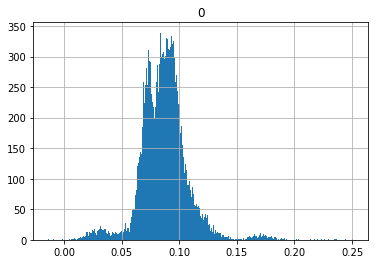

In [231]:
# Plot prediction distribution
pd.DataFrame(y_pred).astype("float").hist(bins=1000)

In [232]:
from sklearn import preprocessing

prediction_df = pd.DataFrame(y_pred).astype("float")
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(prediction_df)
prediction_df = pd.DataFrame(x_scaled)
prediction_df = pd.concat([prediction_df, application_test_df['SK_ID_CURR']], axis=1)
prediction_df.columns = ['TEMP_TARGET', 'SK_ID_CURR']
prediction_df['TARGET'] = round(prediction_df['TEMP_TARGET'], 1)
prediction_df = prediction_df[['SK_ID_CURR', 'TARGET']]

In [233]:
prediction_df['TARGET'].mean()

0.37917897587383664

In [235]:
prediction_df.groupby(by=['TARGET'])['TARGET'].count()

TARGET
0.0        5
0.1      541
0.2     1332
0.3    14104
0.4    26309
0.5     5381
0.6      487
0.7      483
0.8       60
0.9       34
1.0        8
Name: TARGET, dtype: int64

In [236]:
from google.colab import files

submission_df = prediction_df[['SK_ID_CURR', 'TARGET']]
submission_df.to_csv('submission.csv', index=False)
files.download('submission.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>